<a href="https://colab.research.google.com/github/myrah/AAI2025/blob/dev/aai/InventoryReplenishmentAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

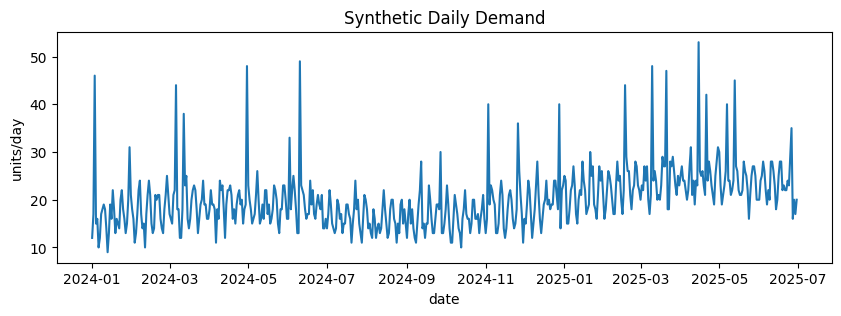

In [14]:
import numpy as np, pandas as pd
rng = np.random.default_rng(7)

start = pd.Timestamp('2024-01-01')
end   = pd.Timestamp('2025-06-30')
idx = pd.date_range(start, end, freq='D')

# Components: baseline + weekly seasonality + yearly seasonality + trend + promo spikes + noise
n = len(idx)
weekly = 10 + 4*np.sin(2*np.pi*idx.dayofweek/7)
yearly = 5 + 3*np.sin(2*np.pi*idx.dayofyear/365)
trend  = np.linspace(0, 8, n)
promos = np.zeros(n); promo_days = rng.choice(n, size=20, replace=False); promos[promo_days] = rng.integers(10, 30, size=20)
noise  = rng.normal(0, 2, n)

demand = np.maximum(0, (weekly + yearly + trend + promos + noise).round())

df = pd.DataFrame({'date': idx, 'demand': demand})
# Train/test split
cut = pd.Timestamp('2024-04-01')
df['split'] = np.where(df['date'] < cut, 'train', 'test')

df.head(), df.tail(), df['split'].value_counts()
# Quick viz (optional):
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(df['date'], df['demand'])
plt.title('Synthetic Daily Demand')
plt.xlabel('date'); plt.ylabel('units/day'); plt.show()


In [15]:
from dataclasses import dataclass

@dataclass
class PolicyParams:
    L: int = 7                 # lead time in days
    CSL: float = 0.95          # target cycle service level
    K: float = 250.0           # fixed order cost per PO
    h: float = 0.2             # holding cost per unit per day
    p: float = 3.0             # stockout penalty per unit short

params = PolicyParams()

# Estimate mean & std from training window
train = df[df['split']=='train']
mu = train['demand'].mean()
sigma = train['demand'].std(ddof=1)

from scipy.stats import norm
z = norm.ppf(params.CSL)

DL_mean = params.L * mu
DL_std  = np.sqrt(params.L) * sigma
ROP = DL_mean + z*DL_std

# EOQ = sqrt(2*K*D/h) with D as daily demand * 365
D_annual = mu * 365
EOQ = np.sqrt((2*params.K*D_annual)/(params.h*365))
ROP, EOQ


(np.float64(154.64017658908963), np.float64(214.19411961844534))

In [16]:
#Create features and fit a minimal model to predict next‑day demand.
feat = df.copy()
feat['dow'] = feat['date'].dt.dayofweek
feat['month'] = feat['date'].dt.month
feat['lag1'] = feat['demand'].shift(1)
feat['lag7'] = feat['demand'].shift(7)
feat['ma7']  = feat['demand'].rolling(7).mean()
feat = feat.dropna()

trainX = feat[feat['date'] < cut]
testX  = feat[feat['date'] >= cut]

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X_cols = ['dow','month','lag1','lag7','ma7']
rf = RandomForestRegressor(n_estimators=200, random_state=0)
rf.fit(trainX[X_cols], trainX['demand'])

pred = rf.predict(testX[X_cols])
mae = mean_absolute_error(testX['demand'], pred)
mae
#Use the forecast to compute a dynamic ROP: replace mu with the forecasted mean and use residual stdev for sigma.
# Residual-based uncertainty
residuals = trainX['demand'] - rf.predict(trainX[X_cols])
sigma_hat = residuals.std(ddof=1)

DL_mean_dyn = params.L * pd.Series(pred, index=testX.index).rolling(params.L).mean().fillna(method='bfill')
DL_std_dyn  = np.sqrt(params.L) * sigma_hat
ROP_dyn = DL_mean_dyn + z*DL_std_dyn
ROP_dyn.head(3)


/tmp/ipython-input-3348793427.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  DL_mean_dyn = params.L * pd.Series(pred, index=testX.index).rolling(params.L).mean().fillna(method='bfill')


,0
91,134.524115
92,134.524115
93,134.524115


In [17]:
#We simulate day‑by‑day operations with backorders, lead time pipeline, and costs.
from collections import deque

class InventorySim:
    def __init__(self, L, h, K, p, init_on_hand=ROP):
        self.L, self.h, self.K, self.p = L, h, K, p
        self.on_hand = init_on_hand
        self.pipeline = deque(maxlen=L)
        for _ in range(L): self.pipeline.append(0)
        self.backlog = 0
        self.cost_holding = 0.0
        self.cost_order = 0.0
        self.cost_stockout = 0.0
        self.orders_log = []
        self.state_log = []

    def step(self, demand, order_qty=0, date=None):
        # Receive
        arriving = self.pipeline.popleft()
        self.on_hand += arriving
        self.pipeline.append(0)

        # Satisfy demand
        available = self.on_hand
        sales = min(available, demand + self.backlog)
        self.on_hand -= sales
        self.backlog = demand + self.backlog - sales

        # Place order
        if order_qty > 0:
            self.pipeline[-1] += order_qty
            self.cost_order += self.K + 0*order_qty  # fixed cost only; extend if variable
            self.orders_log.append({'date': date, 'qty': order_qty})

        # Costs
        self.cost_holding += self.h * max(self.on_hand, 0)
        self.cost_stockout += self.p * self.backlog

        self.state_log.append({'date': date, 'on_hand': self.on_hand, 'backlog': self.backlog, 'arrivals': arriving, 'sales': sales})

    def kpis(self):
        log = pd.DataFrame(self.state_log)
        fill_rate = 1 - (log['backlog'].diff().clip(lower=0).sum() / (log['sales']+log['backlog']).sum())
        return {
            'fill_rate': fill_rate,
            'holding_cost': self.cost_holding,
            'order_cost': self.cost_order,
            'stockout_cost': self.cost_stockout,
            'total_cost': self.cost_holding + self.cost_order + self.cost_stockout
        }
#Test the baseline (s, Q) with static ROP & EOQ.
sim_base = InventorySim(params.L, params.h, params.K, params.p)

hist = df[df['date']>=cut].copy()
hist = hist.reset_index(drop=True)

inv = []
for i, row in hist.iterrows():
    date = row['date']
    d = row['demand']
    # policy: order EOQ when position <= ROP
    inventory_position = sim_base.on_hand + sum(sim_base.pipeline) - sim_base.backlog
    if inventory_position <= ROP:
        sim_base.step(d, order_qty=int(max(1, round(EOQ))), date=date)
    else:
        sim_base.step(d, order_qty=0, date=date)
    inv.append({'date': date, 'on_hand': sim_base.on_hand, 'backlog': sim_base.backlog})

kpi_base = sim_base.kpis(); kpi_base


{'fill_rate': np.float64(0.9480356502240941),
 'holding_cost': np.float64(9301.2869747548),
 'order_cost': 11000.0,
 'stockout_cost': np.float64(1858.5430474473976),
 'total_cost': np.float64(22159.830022202197)}

In [18]:
from pydantic import BaseModel, ConfigDict

class Obs(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    date: pd.Timestamp
    on_hand: float
    backlog: float
    pipeline: int

class Memory(BaseModel):
    last_forecast: float | None = None
    last_action: str | None = None

# Tools

def tool_forecast(current_idx, horizon, series_pred, default_mu):
    # average of next L forecast or fallback
    window = series_pred[current_idx: current_idx+horizon]
    if len(window) == 0:
        return default_mu * horizon
    return float(np.maximum(0, window.mean()) * horizon)

def tool_optimize(order_up_to, inventory_position):
    q = max(0, order_up_to - inventory_position)
    return int(round(q))

def tool_execute(sim: InventorySim, demand, qty, date):
    sim.step(demand, order_qty=qty, date=date)

In [19]:
class ReplenishmentAgent:
    def __init__(self, params: PolicyParams, S_buffer=1.2):
        self.params = params
        self.mem = Memory()
        self.S_buffer = S_buffer  # buffer above ROP

    def decide(self, obs: Obs, forecast_DL):
        # inventory position
        inv_pos = obs.on_hand + obs.pipeline - obs.backlog
        # compute S (order-up-to) as ROP + buffer * expected DL demand
        S = ROP + self.S_buffer * forecast_DL
        if inv_pos <= ROP:
            action = 'order_to_S'
        else:
            action = 'noop'
        return action, int(round(max(0, S - inv_pos)))

    def act(self, action, qty, sim, demand, date):
        if action == 'order_to_S' and qty > 0:
            tool_execute(sim, demand, qty, date)
            self.mem.last_action = f'PO {qty}'
        else:
            tool_execute(sim, demand, 0, date)
            self.mem.last_action = 'noop'
#Run the agent over the test window using the ML forecast for dynamic DL.
sim_agent = InventorySim(params.L, params.h, params.K, params.p)
agent = ReplenishmentAgent(params, S_buffer=1.1)

series_pred = pd.Series(pred, index=testX.index)  # next-day predictions aligned to test index
hist = df[df['date']>=cut].reset_index(drop=True)

for i, row in hist.iterrows():
    date = row['date']; d = row['demand']
    obs = Obs(date=date, on_hand=sim_agent.on_hand, backlog=sim_agent.backlog, pipeline=sum(sim_agent.pipeline))
    # plan
    forecast_DL = tool_forecast(i, params.L, series_pred, default_mu=mu)
    action, qty = agent.decide(obs, forecast_DL)
    # act
    agent.act(action, qty, sim_agent, d, date)

kpi_agent = sim_agent.kpis(); kpi_agent


{'fill_rate': np.float64(0.95046089704854),
 'holding_cost': np.float64(8213.286974754803),
 'order_cost': 12500.0,
 'stockout_cost': np.float64(1822.5430474473974),
 'total_cost': np.float64(22535.8300222022)}

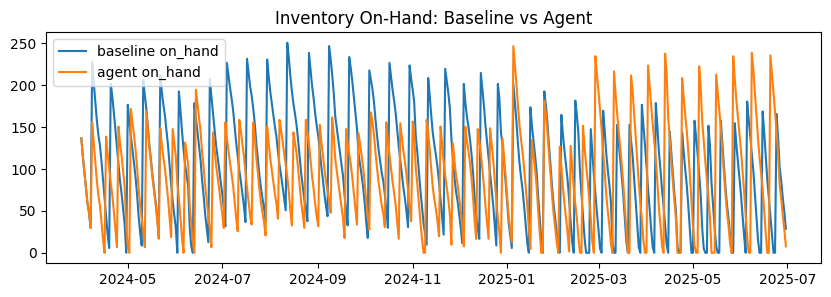

In [20]:
pd.DataFrame([{'policy':'baseline_(s,Q)', **kpi_base}, {'policy':'agentic', **kpi_agent}])
log_base  = pd.DataFrame(sim_base.state_log)
log_agent = pd.DataFrame(sim_agent.state_log)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(log_base['date'], log_base['on_hand'], label='baseline on_hand')
plt.plot(log_agent['date'], log_agent['on_hand'], label='agent on_hand')
plt.legend(); plt.title('Inventory On‑Hand: Baseline vs Agent'); plt.show()


In [21]:
def kpi_table(k1, k2):
    return pd.DataFrame([
        {'KPI':'Fill rate', 'Baseline':k1['fill_rate'], 'Agent':k2['fill_rate']},
        {'KPI':'Holding cost', 'Baseline':k1['holding_cost'], 'Agent':k2['holding_cost']},
        {'KPI':'Order cost', 'Baseline':k1['order_cost'], 'Agent':k2['order_cost']},
        {'KPI':'Stockout cost', 'Baseline':k1['stockout_cost'], 'Agent':k2['stockout_cost']},
        {'KPI':'Total cost', 'Baseline':k1['total_cost'], 'Agent':k2['total_cost']},
    ])

kpi_table(kpi_base, kpi_agent)


,KPI,Baseline,Agent
0,Fill rate,0.948036,0.950461
1,Holding cost,9301.286975,8213.286975
2,Order cost,11000.000000,12500.000000
3,Stockout cost,1858.543047,1822.543047
4,Total cost,22159.830022,22535.830022
